In [7]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

nb_classes =2 
splitting = 'custom'
data_setting = 'rawflt'#'stftflt'
model_setting = 'dl4tsc_inc'#'DenseNet121'

clean = True

### data collecting

In [8]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [9]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [10]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [11]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    12377
0     3658
dtype: int64

val: 
1    4124
0    1221
dtype: int64

test: 
1    11457
0     1157
dtype: int64


## Loading MosquitoNet & Building top model

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

data = Dataset('Wingbeats')
print(data.target_classes)

dataset = data
splitting='random'
flag = ''
traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
using_conv2d = False
base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

base_model.load_weights(traincf.top_weights_path)
base_model.trainable = False

if data_setting == 'rawflt':
    
    if model_setting=='dl4tsc_inc':
        base_output = base_model.layers[-2].output
        intermediate = Dense(nb_classes, activation=None)(base_output)
        new_output = Activation("softmax")(intermediate)
        model = Model(inputs=base_model.inputs, outputs=new_output)
    else:
        model = Sequential()
        for layer in base_model.layers[:-1]: # go through until last layer
            model.add(layer)
        #     print(layer.trainable)
        model.add(Dense(nb_classes, activation=None))
        model.add(Activation('softmax'))
elif data_setting == 'stftflt':
    base_output = base_model.layers[-2].output
    new_output = Dense(nb_classes, activation="softmax")(base_output)
    model = Model(inputs=base_model.inputs, outputs=new_output)

model.summary()

# # inputs = Input(shape=)
# inputs = Input(shape=base_model.input.shape[1:])
# x = base_model(inputs, training=False)
# # x =  GlobalAveragePooling2D()(x)
# # x = Dropout(0.2)(x)
# outputs = Dense(3)(x)
# model = Model(inputs, outputs)
# model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
max_pooling1d_21 (MaxPooling1D) (None, 5000, 1)      0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_108 (Conv1D)             (None, 5000, 32)     416         input_4[0][0]                    
______________________________________________________________________________________________

### training top layer

In [7]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting, model_name=f"Flies_TL_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy', epochs=20)

h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats=''),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats=''),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
              callbacks=[traincf.callbacks_list])

Epoch 1/20
502/502 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.7752
Epoch 00001: val_accuracy improved from -inf to 0.80486, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_rawflt_dl4tsc_inc_random.h5
502/502 [==============================] - 289s 575ms/step - loss: 0.5120 - accuracy: 0.7752 - val_loss: 0.4199 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 2/20
501/502 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8175
Epoch 00002: val_accuracy improved from 0.80486 to 0.82694, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_rawflt_dl4tsc_inc_random.h5
502/502 [==============================] - 44s 89ms/step - loss: 0.4095 - accuracy: 0.8175 - val_loss: 0.3904 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 3/20
501/502 [============================>.] - ETA: 0s - loss: 0.3882 - accuracy: 0.8308
Epoch 00003: val_accuracy improved from 0.82694 to 0.83442, saving model to /home/k

## Training whole model

In [8]:
from tensorflow.keras.optimizers import Adam

base_model.trainable = True
model.summary()

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting, model_name=f"Flies_TL_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy', epochs=100)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5000, 1)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 5000, 32)     416         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 5000, 32)     192         input_2[0][0]                    
____________________________________________________________________________________________

In [9]:
h = model.fit(train_generator(X_train, y_train, 
                              batch_size=traincf.batch_size,
                              target_names=np.unique(y_test).tolist(),
                              setting=traincf.setting,
                              preprocessing_train_stats=''),
              steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
              epochs = traincf.epochs,
              validation_data = valid_generator(X_val, y_val,
                                                batch_size=traincf.batch_size,
                                                target_names=np.unique(y_test).tolist(),
                                                setting=traincf.setting,
                                                preprocessing_train_stats=''),
              validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
              callbacks=[traincf.callbacks_list])

Epoch 1/100
502/502 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.8059
Epoch 00001: val_accuracy improved from -inf to 0.86305, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_rawflt_dl4tsc_inc_random.h5
502/502 [==============================] - 142s 283ms/step - loss: 0.7117 - accuracy: 0.8059 - val_loss: 0.4161 - val_accuracy: 0.8630 - lr: 1.0000e-05
Epoch 2/100
501/502 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8651
Epoch 00002: val_accuracy improved from 0.86305 to 0.88924, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_rawflt_dl4tsc_inc_random.h5
502/502 [==============================] - 137s 273ms/step - loss: 0.3932 - accuracy: 0.8651 - val_loss: 0.3587 - val_accuracy: 0.8892 - lr: 1.0000e-05
Epoch 3/100
501/502 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8857
Epoch 00003: val_accuracy improved from 0.88924 to 0.90234, saving mod

In [10]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [11]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.8898454926990547

# #

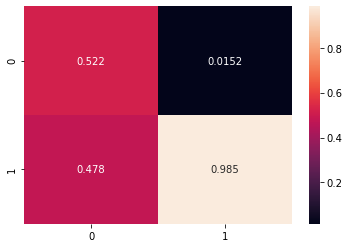

In [14]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='.3g')



## result of rawflt

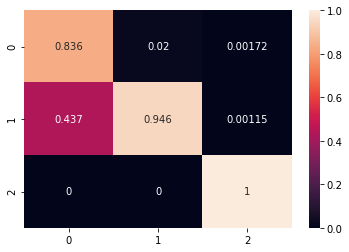

In [27]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)

sns.heatmap(cm, annot=True, fmt='.3g')

# Check if misclassifications are the same for normal training vs transfer learning